In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import torch

from monai.visualize.utils import matshow3d

from pathlib import Path

from let.data import LETDatasetInMemory
from let.model import SegResNetLETPredictor

## Data handling

Please download our experimental data from https://rodare.hzdr.de/record/2764. Then, create a `data` directory located at the same level as the `README.md` and within this, a subdirectory named `waterphantom`.
Then, unzip the `water_phantom.zip` file to the `waterphantom` directory.
After doing this, you are good to continue.


In [2]:
data_dir = Path("../../data/waterphantom/")
sorted(data_dir.iterdir())

[PosixPath('../../data/waterphantom/phantom0001_plan1'),
 PosixPath('../../data/waterphantom/phantom0001_plan1_1beam')]

In [3]:
plan_dir = data_dir / "phantom0001_plan1"
rois = np.load(plan_dir / "ROIs.npy", allow_pickle=True).item()
rois.keys()

dict_keys(['CTV', 'External', 'Brain', 'Brainstem'])

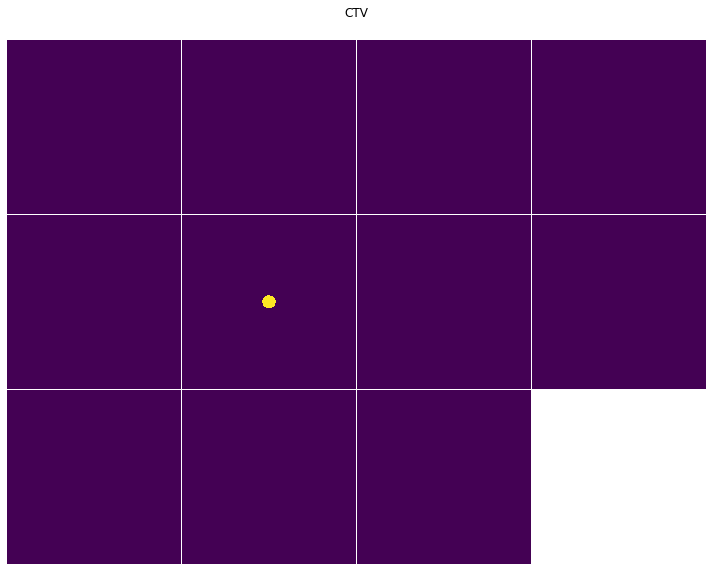

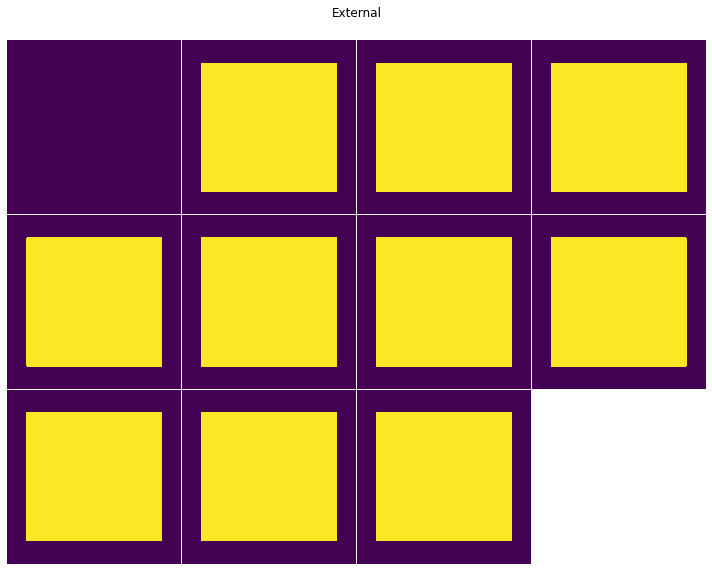

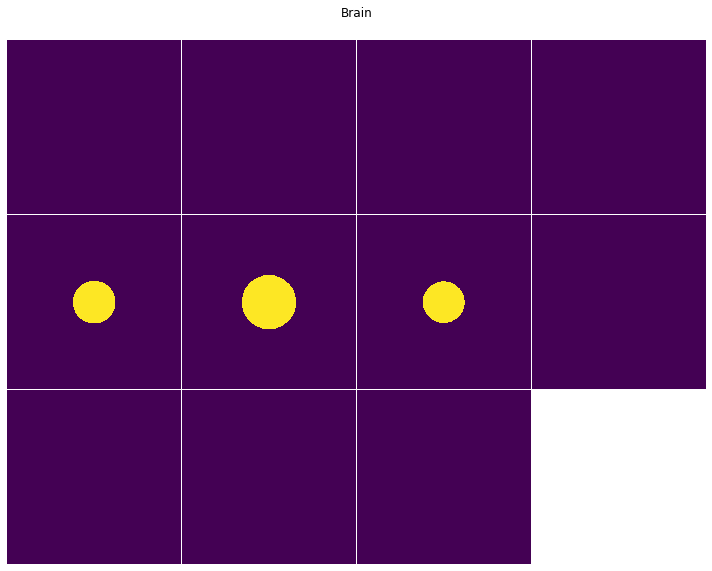

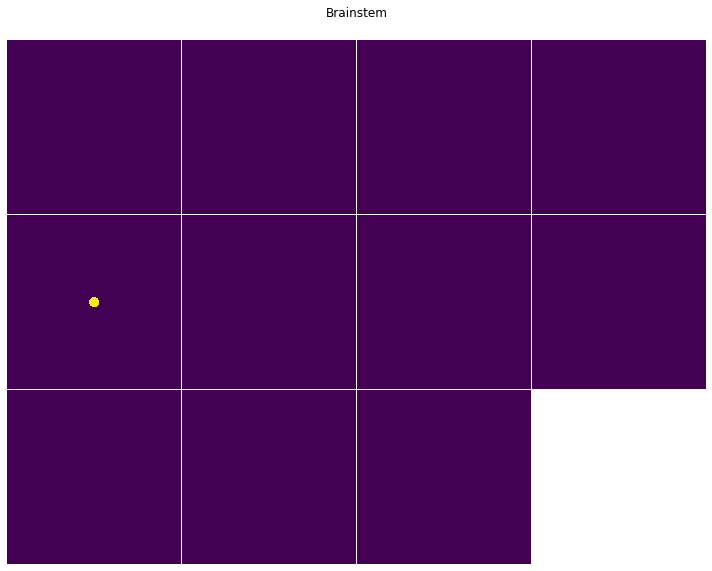

In [4]:
for k in rois:
    matshow3d(rois[k], every_n=50)
    plt.title(k)
    plt.show()

In [5]:
rois["CTV"].shape, rois["CTV"].dtype

((510, 512, 512), dtype('bool'))

In [6]:
dose = np.load(plan_dir / "plan_dose.npy")
print(dose.shape)

let = np.load(plan_dir / "LETd.npy")
print(let.shape)

(510, 512, 512)
(510, 512, 512)


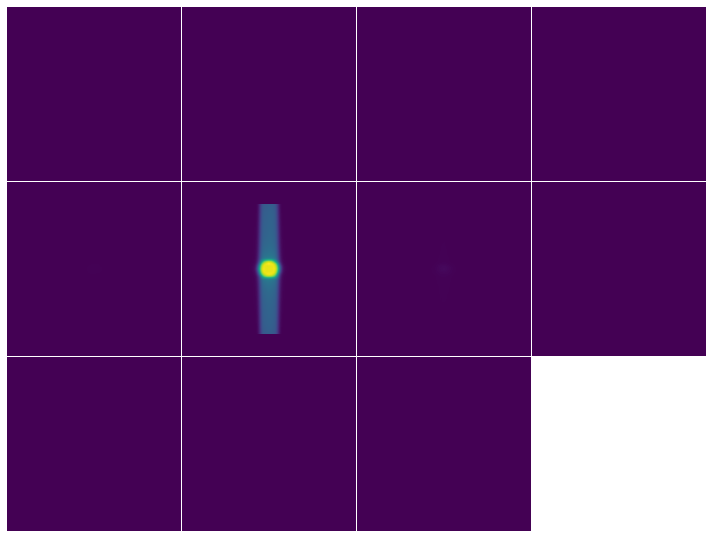

In [7]:
_ = matshow3d(dose, every_n=50)

In [8]:
dose.min(), dose.max()

(0.0, 62.17881)

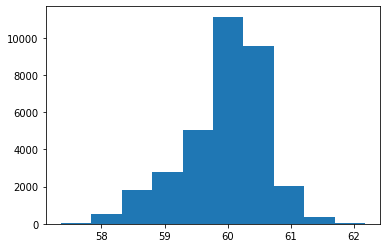

In [9]:
_ = plt.hist(dose[rois["CTV"]])

In [10]:
dose_ctv = dose[rois["CTV"]]
print(np.mean(dose_ctv))

59.953793


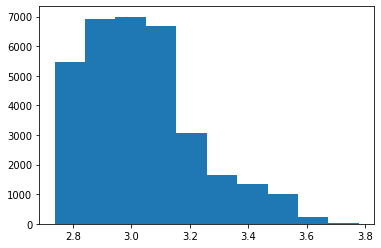

In [11]:
_ = plt.hist(let[rois["CTV"]])

No manual loading of the files of each plan is required, we provide a dataset class for this purpose.

In [12]:
# the threshold on the normalized dose per voxel, below which we clip the corresponding LET to zero
dose_threshold = 0.04 # 2 / 60
dose_threshold

0.04

In [13]:
# not all parameters are provided, please check the documentation

dataset = LETDatasetInMemory(
    data_dir=data_dir,
    plan_ids=["phantom0001_plan1"],
    ct_filename="CT.npy", # not useful for a water phantom
    dose_filename="plan_dose.npy",
    let_filename="LETd.npy",
    roi_filename="ROIs.npy",
    return_rois=["External", "CTV", "Brainstem", "Brain"],
    #crop_size=(64, 64, 64),
    clip_let_below_dose=dose_threshold,
)

  0%|          | 0/1 [00:00<?, ?it/s]

phantom0001_plan1: Loading image data
phantom0001_plan1: Use CTV for dose normalization.
phantom0001_plan1: Clip LET to zero where dose is below 0.04 Gy.
phantom0001_plan1: CT windowing to -500, 2000
phantom0001_plan1: CT normalisation to unit range.
phantom0001_plan1: Extracting ROIs ['External', 'CTV', 'Brainstem', 'Brain']
phantom0001_plan1: Cropping based on 'External' bounding box.
Cropped dose (224, 320, 320)
Cropped let (224, 320, 320)
Cropped ct (224, 320, 320)
Cropped Mask_External (224, 320, 320)
Cropped Mask_CTV (224, 320, 320)
Cropped Mask_Brainstem (224, 320, 320)
Cropped Mask_Brain (224, 320, 320)
phantom0001_plan1: Apply preprocessing transformations


Successfully read data from 1 plans.


In [14]:
sample = dataset[0]

In [15]:
type(sample)

dict

In [16]:
for k, v in sample.items():
    if isinstance(v, (torch.Tensor, np.ndarray)):
        print(f"{k}:", type(v), v.shape, v.dtype, "range=", v.min(), "-", v.max())
    else:
        print(f"{k}:", v)

plan_id: phantom0001_plan1
dose: <class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 224, 320, 320]) torch.float32 range= tensor(0.) - tensor(1.0371)
dose_was_divided_by: 59.953793
let: <class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 224, 320, 320]) torch.float32 range= tensor(0.) - tensor(5.8927)
ct: <class 'monai.data.meta_tensor.MetaTensor'> torch.Size([1, 224, 320, 320]) torch.float32 range= tensor(1.) - tensor(1.)
Mask_External: <class 'numpy.ndarray'> (224, 320, 320) bool range= True - True
Mask_CTV: <class 'numpy.ndarray'> (224, 320, 320) bool range= False - True
Mask_Brainstem: <class 'numpy.ndarray'> (224, 320, 320) bool range= False - True
Mask_Brain: <class 'numpy.ndarray'> (224, 320, 320) bool range= False - True


In [17]:
normalized_dose = sample["dose"].numpy()[0]
print(normalized_dose.shape)

(224, 320, 320)


In [18]:
let = sample["let"].numpy()[0]
ctv = sample["Mask_CTV"]


np.percentile(let[ctv], 98)

3.5197885036468506

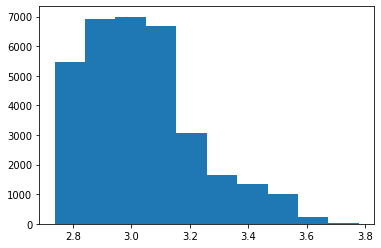

In [19]:
_ = plt.hist(let[ctv])

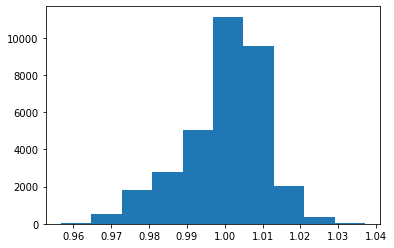

In [20]:
_ = plt.hist(normalized_dose[ctv])

In [21]:
def find_min_bounding_box_slices(normalized_dose, dose_threshold=0.04):
    # Find the indices of non-zero elements
    non_zero_indices = np.nonzero(normalized_dose>=dose_threshold)
    
    # Calculate min and max indices for each dimension
    min_x, max_x = non_zero_indices[0].min(), non_zero_indices[0].max()
    min_y, max_y = non_zero_indices[1].min(), non_zero_indices[1].max()
    min_z, max_z = non_zero_indices[2].min(), non_zero_indices[2].max()
    
    # Create slices for each dimension
    slices = (slice(min_x, max_x+1), slice(min_y, max_y+1), slice(min_z, max_z+1))
    
    return slices

# find the 
slices = find_min_bounding_box_slices(sample["dose"], dose_threshold)
slices

(slice(0, 1, None), slice(0, 82, None), slice(0, 320, None))

In [22]:
print(sample["dose"].shape)
print(sample["dose"][slices].shape)

torch.Size([1, 224, 320, 320])
torch.Size([1, 82, 320, 320])


In [23]:
plot_every_n = 5

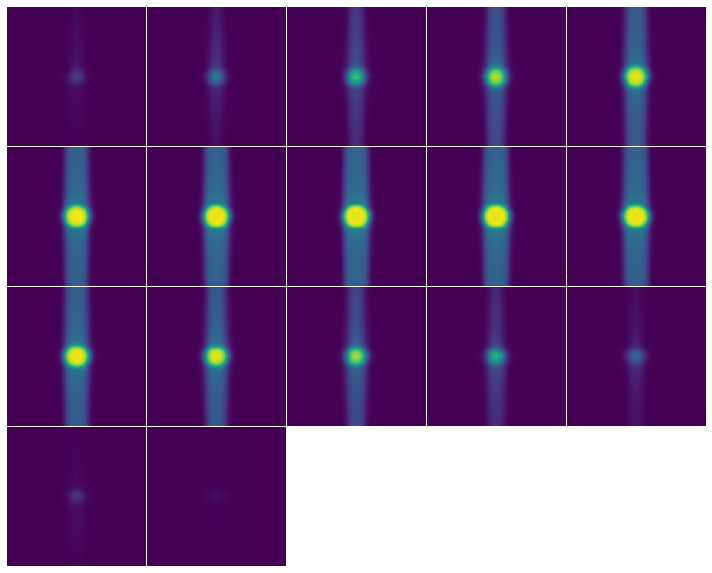

In [24]:
_ = matshow3d(
    sample["dose"][slices],
    every_n=plot_every_n
)

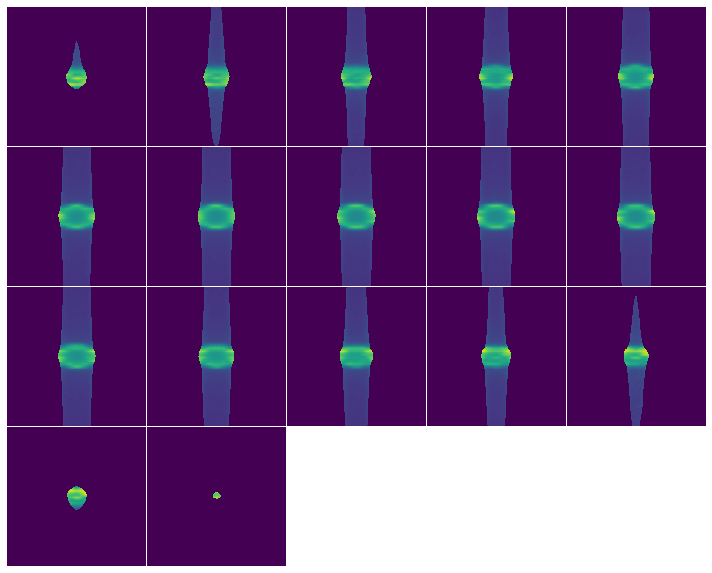

In [25]:
_ = matshow3d(
    sample["let"][slices],
    every_n=plot_every_n
)

## Model definition and predictions

In [26]:
model = SegResNetLETPredictor(
    loss="mse",
    use_ct=False
)
print(sum(p.numel() for p in model.parameters() if p.requires_grad) / 1.e6, "mio parameters")
model

4.744017 mio parameters


SegResNetLETPredictor(
  (loss_fn): MSELoss()
  (metric_fn): L1Loss()
  (model): SegResNet(
    (act_mod): LeakyReLU(negative_slope=0.1, inplace=True)
    (convInit): Convolution(
      (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
    )
    (down_layers): ModuleList(
      (0): Sequential(
        (0): Identity()
        (1): ResBlock(
          (norm1): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (act): LeakyReLU(negative_slope=0.1, inplace=True)
          (conv1): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
          (conv2): Convolution(
            (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
        )
      )
      (1): Sequential(
   

In [27]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)
trainer = pl.Trainer()

# NOTE: no model training has been performed here, so don't expect good predictions!

batch_predictions = trainer.predict(model, loader)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/starke88/.conda/envs/let/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
/home/starke88/.conda/envs/let/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 48 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [28]:
predicted_let = batch_predictions[0][0]
print(predicted_let.shape)

torch.Size([1, 224, 320, 320])


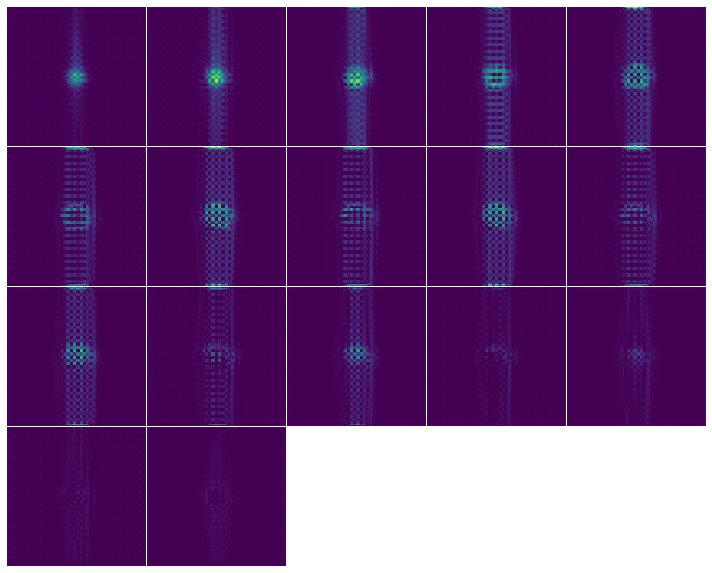

In [29]:
_ = matshow3d(predicted_let[slices], 
              every_n=plot_every_n)

## Now we make the same prediction but use our trained model

In order for this to work, please download our experimental data from https://rodare.hzdr.de/record/2764.
Then, unzip the `analysis_data.zip` file. Copy the file `analysis_data/dd_pbs/Dose-LETd/clip_let_below_0.04/segresnet/all_trainvalid_data/training/lightning_logs/version_6358843/checkpoints/last.ckpt` to the `data` directory created in the beginning.
After doing this, you are good to continue.


In [30]:
model_weight_file = Path("../../data/last.ckpt")
assert model_weight_file.exists()


In [31]:
model = model.load_from_checkpoint(model_weight_file)

In [32]:
batch_predictions_trained = trainer.predict(model, loader)

Predicting: 0it [00:00, ?it/s]

torch.Size([1, 224, 320, 320])


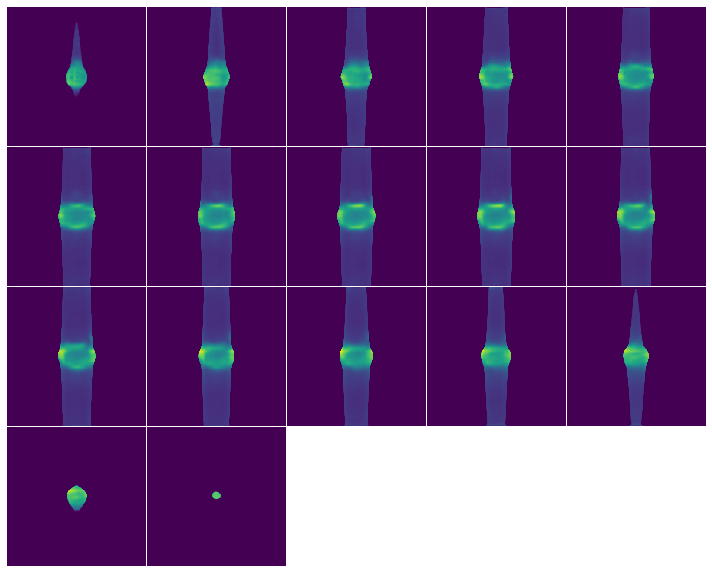

In [33]:
predicted_let = batch_predictions_trained[0][0]
print(predicted_let.shape)

_ = matshow3d(predicted_let[slices], 
              every_n=plot_every_n)

## Evaluation of the prediction error

In [34]:
error_let = sample["let"] - predicted_let
els = error_let[slices]

In [35]:
error_let.min(), error_let.max()

(tensor(-6.2996), tensor(2.0252))

In [36]:
els.min(), els.max()

(tensor(-6.2996), tensor(2.0252))

In [37]:
 def cm_to_inch(cm):
    return cm / 2.54


def inch_to_cm(inch):
    return inch * 2.54

def make_plot(dataset, preds, 
              n_slices=4, 
              alpha=0.6, 
              batch_idx=0, 
              let_vmin=0, 
              let_vmax=10, 
              err_vmin=-2, 
              err_vmax=2,
              cbar_orient="vertical",
              error="absolute",
              cbar_textsize=8):
    
    f, ax = plt.subplots(2, 2, figsize=(cm_to_inch(15), cm_to_inch(15)))
    
    # for training data
    
    #batch_idx = 0  # batch_idx = sample_idx since we use batch size of one and no shuffling
    data = dataset[0]
    
    # how many voxels with dose greater than 1 Gy / fraction of volume 
    # used to clip the z dimension to interesting slices
    fraction_vol_per_slice_cropped = np.sum(data["dose"][0] > 0.1, axis=(1, 2)) / np.prod(data["dose"][0].shape[1:])
    slice_idx_cropped = np.where(fraction_vol_per_slice_cropped > 0.05)[0]
    first, last = slice_idx_cropped[0], slice_idx_cropped[-1]
    print(slice_idx_cropped)

    cropped_shape = data["ct"][0, first:last].shape[0]
    every_n = int(np.ceil(cropped_shape / n_slices))
    
    #data = ds_train[batch_idx] # NOTE: here we assume that we dont shuffle in the dataloader, otherwise predictions and data dont match!
    
    pred = preds
    print(pred.shape, data["let"][0].shape)
    if error == "absolute":
        err =  (data["let"][0] - pred[0]) # discards channel dimension
        err_title = "MC LET$_d$ - NN LET$_d$"
    else:
        err =  (data["let"][0] - pred[0]) / data["let"][0] # discards channel dimension
        err_title = "MC LET$_d$ - NN MC LET$_d$ / MC LET$_d$"

    # NOTE: we set zero error to nan to avoid lots of green in the plots which distracts from
    # actual deviations. nans are not plotted by matplotlib!
    err[torch.isclose(err, torch.zeros_like(err))] = torch.nan
    print(err[~err.isnan()].min(), err[~err.isnan()].max())

    ax[1, 0].set_title("NN LET$_d$", pad =-500)
    alph = 1.
    if "ct" in data:
        _ = matshow3d(data["ct"][0, first:last], every_n=every_n, cmap="gray", fig=ax[1, 0])
        alph = alpha
    _ = matshow3d(pred[0, first:last], every_n=every_n, 
                  cmap="jet", fig=ax[1, 0], 
                  alpha=alph, 
                  vmin=let_vmin, vmax=let_vmax)
    cbar = plt.colorbar(ax[1, 0].get_images()[-1], ax=ax[1, 0], orientation=cbar_orient, fraction=0.073, aspect = 12)
    cbar_ax = cbar.ax
    cbar_ax.text(
            0.5,
            0.5,
            r"keV$\cdot (\mu \rm m)^{-1}$",
            ha="center",
            va="center",
            rotation=270,
            size=cbar_textsize,
            transform=cbar_ax.transAxes,
        )
    
    ax[1, 1].set_title(err_title, pad =-500)
    if "ct" in data:
        _ = matshow3d(data["ct"][0, first:last], every_n=every_n, cmap="gray", fig=ax[1, 1])
    _ = matshow3d(err[first:last], every_n=every_n, 
                  cmap="jet", fig=ax[1, 1], 
                  vmin=err_vmin, vmax=err_vmax, 
                  alpha=alph)
    cbar = plt.colorbar(ax[1, 1].get_images()[-1], ax=ax[1, 1], orientation=cbar_orient, fraction=0.073, aspect = 12)
    cbar_ax = cbar.ax
    cbar_ax.text(
            0.5,
            0.5,
            r"keV$\cdot (\mu \rm m)^{-1}$",
            ha="center",
            va="center",
            rotation=270,
            size=cbar_textsize,
            transform=cbar_ax.transAxes,
        )
    
    # first row just shows the input data
    if "ct" in data:
        _ = matshow3d(data["ct"][0, first:last], every_n=every_n, cmap="gray", fig=ax[0, 1])    
    _ = matshow3d(data["let"][0, first:last], every_n=every_n, 
                  cmap="jet", fig=ax[0, 1], 
                  alpha=alph, 
                  vmin=let_vmin, vmax=let_vmax)
    ax[0, 1].set_title("MC LET$_d$", pad =-500)
    cbar = plt.colorbar(ax[0, 1].get_images()[-1], ax=ax[0, 1], orientation=cbar_orient, fraction=0.073, aspect = 12)
    cbar_ax = cbar.ax
    cbar_ax.text(
            0.5,
            0.5,
            r"keV$\cdot (\mu \rm m)^{-1}$",
            ha="center",
            va="center",
            rotation=270,
            size=cbar_textsize,
            transform=cbar_ax.transAxes,
        )
    
    if "ct" in data:
        _ = matshow3d(data["ct"][0, first:last], every_n=every_n, cmap="gray", fig=ax[0, 0])
    
    _ = matshow3d(data["dose"][0, first:last], every_n=every_n, 
                  cmap="jet", 
                  fig=ax[0, 0], 
                  alpha=alph)
    ax[0, 0].set_title("Dose", pad =-500)
    cbar = plt.colorbar(ax[0, 0].get_images()[-1], ax=ax[0, 0], orientation=cbar_orient, fraction=0.073, aspect = 12)
    cbar_ax = cbar.ax
    cbar_ax.text(
            0.5,
            0.5,
            r"Gy(RBE), normalized",
            ha="center",
            va="center",
            rotation=270,
            size=cbar_textsize,
            transform=cbar_ax.transAxes,
        )
    #plt.show()
    plt.tight_layout(pad = 0.5)

[ 7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30
 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54
 55 56 57 58 59 60 61 62 63 64 65 66 67]
torch.Size([1, 224, 320, 320]) torch.Size([224, 320, 320])
tensor(-6.2996) tensor(2.0252)


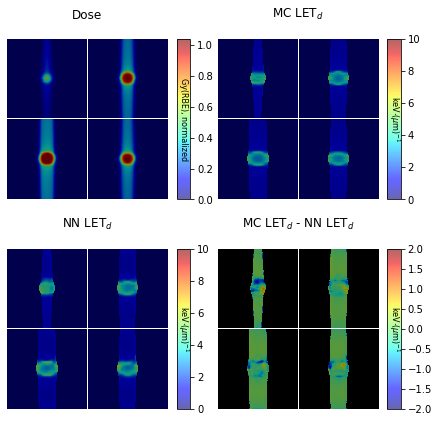

In [38]:
make_plot(dataset, predicted_let)

In [39]:
CTV = dataset[0]["Mask_CTV"]
relevant_dose_area = dataset[0]["dose"][0].numpy() >= 0.04

brain = dataset[0]["Mask_Brain"]
brainstem = dataset[0]["Mask_Brainstem"]

brain_rda = brain & relevant_dose_area
brainstem_rda = brainstem & relevant_dose_area

CTV.shape,relevant_dose_area.shape, brain_rda.shape

((224, 320, 320), (224, 320, 320), (224, 320, 320))

In [41]:
for roiname, roi in zip(["CTV", "Relevant dose area", "Brain", "Brainstem", "relevant_dose_area_Brain", "relevant_dose_area_Brainstem"], 
                        [CTV, relevant_dose_area, brain, brainstem, brain_rda, brainstem_rda]):
    print()
    print(roiname)
    print("----------")
    
    error_median_dw = np.median(dataset[0]["let"][0][roi]) - np.median(predicted_let[0][roi])
    print("Median Error (DW):", error_median_dw)
    
    error_median_vw = np.median(dataset[0]["let"][0][roi] - predicted_let[0][roi])
    print("Median Error (VW):", error_median_vw)
    
    error_98_dw = np.percentile(dataset[0]["let"][0][roi], 98) - np.percentile(predicted_let[0][roi], 98)
    print("98 percentile of error (DW):", error_98_dw)
    
    error_98_vw = np.percentile(dataset[0]["let"][0][roi] - predicted_let[0][roi], 98)
    print("98 percentile of error (VW):", error_98_vw)


CTV
----------
Median Error (DW): -0.14753795
Median Error (VW): -0.1732192
98 percentile of error (DW): -0.30530238151550293
98 percentile of error (VW): 0.1432201862335205

Relevant dose area
----------
Median Error (DW): 0.030599117
Median Error (VW): 0.012320876
98 percentile of error (DW): -0.3808966255187993
98 percentile of error (VW): 0.3395352661609664

Brain
----------
Median Error (DW): 0.0
Median Error (VW): 0.0
98 percentile of error (DW): -0.384437866210936
98 percentile of error (VW): 0.23752551078796247

Brainstem
----------
Median Error (DW): -0.6247268
Median Error (VW): -0.6240413
98 percentile of error (DW): -0.3450789260864262
98 percentile of error (VW): 0.7747659015655517

relevant_dose_area_Brain
----------
Median Error (DW): -0.28878272
Median Error (VW): -0.06277633
98 percentile of error (DW): -0.36607711791991804
98 percentile of error (VW): 0.46486727714538634

relevant_dose_area_Brainstem
----------
Median Error (DW): -0.6247268
Median Error (VW): -0.6240